# Course Project No 3 - Part 2 - House prices - 1 of 2

## Goal of this House Prices project

Estimate the price of 500 houses using a model based on 2'430 house prices, analyzing a dataset made of 82 features

## Structure of the Notebook

This 2nd part of the Course Project No 3 is splitted in two Notebooks.

* First Notebook contains all the work to clean the train dataset and prepare the test dataset.

    At the end of this first Notebook, two new CSV files are created in the 'data' folder using the cleaned versions of the datasets.

    > house-prices-cleaned.csv: Cleaned version of the Train dataset

    > house-prices-test-cleaned.csv: Adapted version of the Train dataset, according to modifications done in the structure of the Train dataset.

* Second Notebook will work on the cleaned CSV files to do:

## Import base libraries

Let's import all the base libraries that we will use in this Notebook

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


## Load the datasets

So we have two files, one for the train dataset, the other for the test.

As we will have to duplicate, transform, maybe drop columns in both dataset, I've decided to concat both into one big dataset, and define different functions to build the global dataframe and extract train and test datasets from it.

### Train Dataset

In [2]:
train_df = pd.read_csv(os.path.join('data','house-prices.csv'))
print("Size of the train dataset:", train_df.shape)
train_df.head(3)

Size of the train dataset: (2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


### Test Dataset

In [3]:
test_df = pd.read_csv(os.path.join('data','house-prices-test.csv'))
print("Size of the test dataset:", test_df.shape)
test_df.head(3)

Size of the test dataset: (500, 81)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,92,0,NaN,NaN,NaN,0,10,2009,WD,Normal
2,2397,528144030,60,RL,86.0,11065,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,10,2006,New,Partial


### Merge datasets into one dataframe

The merged dataset will be stored in a variable named *data_df*

> Note: Test dataset is missing the 'SalePrice' column. We must add an empty column to it before concatenating it with train dataset

In [4]:
# Define target column name as a variable
target_column='SalePrice'

# Add empty 'SalePrice' columnto Test dataset
test_df[target_column] = np.nan

# Function that concat datasets received as parameter and replace our global data_df variable
def concatTrainAndTestDataset(train_df, test_df):
    global data_df
    print("Rebuild global dataset with train_df {} and test_df {}".format(train_df.shape, test_df.shape))
    data_df=pd.concat([train_df.copy(), test_df.copy()], ignore_index=True, sort=False)
    return

# Concat both dataframe
concatTrainAndTestDataset(train_df, test_df)

# Verify size of resulting dataframe
print("Size of global dataframe. Must be (2930,82):\t", data_df.shape)

# Define function that returns the train dataset
def getTrainDataset():
    global data_df
    global target_column
    
    return data_df[np.logical_not(data_df[target_column].isnull())]

# Define function the test dataset
def getTestDataset():
    global data_df
    global target_column
    
    return data_df[data_df[target_column].isnull()]

# Verify size of trainig dataframe
print("Size of train dataframe. Must be (2430,82):\t", getTrainDataset().shape)

# Verify size of resulting dataframe
print("Size of test dataframe. Must be (500,82):\t", getTestDataset().shape)




Rebuild global dataset with train_df (2430, 82) and test_df (500, 82)
Size of global dataframe. Must be (2930,82):	 (2930, 82)
Size of train dataframe. Must be (2430,82):	 (2430, 82)
Size of test dataframe. Must be (500,82):	 (500, 82)


## Utility functions

Before working on our dataset, let's define some utility functions that will be used in our Notebook.
This will simplify our code.

### Drop and One-encode

Along the Notebook, we will have to drop columns and one-encode others.

Instead of dropping column immediately, we had the columns to drop in a *column_to_drop* set to be removed later. This trick allows us to run cell notebook several time without side effect. Of course, as soon as the drop command is applied on this set, the previous cells might not work and the notebook should be rerun from beginning.

Same for one-hot encoding, we define a *columns_to_encode* set() to perform the one-hot encoding later.

We create two functions to manipulate those two variables and a third one to execute the job, taking care of the global variables

> Note 1: One-hot encoding must be done prior to the drop call as some of the flagged columns to be dropped are created by the 'one-hot' encoding process.

> Note 2: Reset the two variables *columns_to_drop* and *columns_to_encode* afterward in case we reuse them


In [5]:
# Store the columns to be dropped
columns_to_drop = set()

# Store the columns to be ont-hot encoded
columns_to_encode = set()

# Function to add columns to be dropped
def addColumnToDropList(columns = []):
    """
    Adds columns received as parametr to columns_to_drop global var
    """
    global columns_to_drop
    for c in columns:
        columns_to_drop.add(c)
    print("Columns flaged as 'to be removed':", ",".join(columns_to_drop))

# Function to add columns to be one-hot encoded
def addColumnToOneHotEncoding(columns = []):
    """
    Adds columns received as parametr to columns_to_encode global var
    """
    global columns_to_encode
    for c in columns:
        columns_to_encode.add(c)
    print("Columns flaged as 'to be one-hot encoded':", ",".join(columns_to_encode))
    
def dropAndEncode():
    global columns_to_drop
    global columns_to_encode
    global data_df
    """
    This function handle drop and one-hot encoding on the data_df dataset
    """
    print("Size of the dataframe BEFORE applying one-hot encoding:", data_df.shape)
    if (len(columns_to_encode) > 0):
        print("  Do 'one-hot' encoding on:", columns_to_encode)
        data_df = pd.get_dummies(data_df, columns=columns_to_encode)
    print("Size of the dataframe AFTER applying one-hot encoding:", data_df.shape)
    if (len(columns_to_drop) > 0):
        print("  Drop columns:", columns_to_drop)
        data_df.drop(columns_to_drop, axis=1, inplace=True)
    print("Size of the dataframe AFTER dropping column and applying one-hot encoding:", data_df.shape)

    # reset global var as the job has been done
    columns_to_drop = set()
    columns_to_encode = set()  


### Where Clause Replacement

On columns from which we could extract binary information (for example, does the house has a pool or not?), instead of doing a one-hot encoding exercice after replacing values, we can define a function using the *np.where()* method to globaly modified the column values in one shot.

In [6]:
def whereClauseReplacement(column, condition, true_value=0, false_value=1, drop_original_column = True, suffix=' Exists'):
    """
    Function take a np.array of boolean and a column name to apply an np.where call on it.
    true_value and false_value default to 1 and 0
    The resulting value is added in a new column using the column name parameter and a suffix parameter.
    A drop_original_column can be provided to decide if the orignal column should be dropped. It is set by default to True
    """
    
    global data_df
    
    print("Doing a binary replacement on column", column)
    new_column = column + suffix
    print("  New column name:", new_column)
    data_df[new_column] =np.where(condition, true_value, false_value)
    if (drop_original_column == True):
        print("  Drop original column")
        addColumnToDropList([column])
    # ensure new column contains at least and no more 2 values
    if (len(data_df[new_column].unique()) != 2):
        raise SystemExit("WARNING: whereClauseReplacement found number of values != 2. Aborting Notebook execution")


### Transform literal ordinal column to numerical one

Most of the ordinal columns, according to documentation, values in those columns are categories written as strings. The following utility function is used to convert literal values by numeric ones. The mapping between literal and numeric values is passed to the function as a dictionnary.


In [7]:
# Function definition to rencode ordinal column to numerical 
def encodeLiteralToNumericValues(column, mapping={}, replacena= None, column_type='int64'):
    """
    This function replaces values in column passed as parameter using the mapping dict provided.
    Key of the dict are used as search value in cells, and if match, cell value is replace by the value
    of mapping[key]
    replacena parameter, if different from None is used as replacement of null values
    Note that dtype of modified column is automatically set to int64 if all values have been replaced with numeric one
    Function also prints the unique values found in the column after transformation. This information could be used
    to validate that we've not missed any replacement.
    We do also ensure that column received as parameter does not contains only a numeric values. if it is the cas, then
    the function simply returns.
    """
    global data_df
    
    print("Encoding column {} to numerical values".format(column))
    # Does the column contains only numeric
    if pd.api.types.is_numeric_dtype(data_df[column].dtype):
        # yes, return
        print("  Column is already numerical. Nothing to do.")
        return
    
    # replace values using mapping
    data_df[column] = data_df[column].map(mapping)
    # replace null values
    if replacena != None:
        data_df[column] = data_df[column].fillna(replacena)
    
    # Do an exit(1) if resulting column is not a numeric one
    if pd.api.types.is_numeric_dtype(data_df[column].dtype) == False:
        raise SystemExit("WARNING: encodeOrdinalColumnToNumeric returns a non numerical column. Aborting Notebook execution")
    else:
        print("  Column successfully encoded with numerical values")
    print("  Values in column:", data_df[column].unique())

    # cast dtype of the newly column to column_type
    data_df[column] = data_df[column].astype(column_type)
    
    return



## Data cleaning

Data in this set is not optimal and has to be cleaned before being used. Here is the methodology followed.


### Drop useless columns

Order and PID columns are useless to fit models, drop them :-)


In [8]:
addColumnToDropList(['Order'])

Columns flaged as 'to be removed': Order


### Handle columns with more than 20% empty cells
Some of the columns contains a huge amount of null cells, we should drop them as they won't be pertinent if we were seeking for data quality.
But, in Machine Learning approach, it's a better choice to keep all the data available, modifying it a little bit to suit model fitting process.
Why seeking for 20% of empty cells in columns ? No specific reason, arbitrary choice :-)

Let's identify those columns.

In [9]:
# Number of lines in dataset
total_line = data_df.shape[0]

# NULL_CELL_LIMIT is the max allowed percentage of null value in a column
NULL_CELL_LIMIT = 0.20

# List of columns that we will drop
identified_column = list()

# Loop in each column and identify the one to drop
for c in data_df.columns:
    no_of_null_cell = data_df[c].isnull().sum()
    if(no_of_null_cell/total_line > NULL_CELL_LIMIT):
        identified_column.append(c)

print("Columns with mode than 20% of empty cells:", ','.join(identified_column))

data_df[identified_column].isnull().sum().sort_values(ascending=False)

Columns with mode than 20% of empty cells: Alley,Fireplace Qu,Pool QC,Fence,Misc Feature


Pool QC         2917
Misc Feature    2824
Alley           2732
Fence           2358
Fireplace Qu    1422
dtype: int64

So, we've found 5 columns. Here is what I've decided to do with them.

#### Pool QC: 

On the whole dataset, we found that only 12 houses are equiped with a pool.
Choice is made to do a one-hot encoding on the 'Pool QC' column to simply identify houses with a pool, by replacing null values by 0, others by 1.

To simplify coding, we define here a function that performs the 'where' binary replacement on a list of dataset, which defaults to our previously initialized variable: dataframe_list


In [10]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with pool:\t",data_df.shape[0] - data_df['Pool QC'].isnull().sum())
print("Number of pool area > 0:\t",data_df[data_df['Pool Area'] > 0]['Pool Area'].count())

whereClauseReplacement('Pool QC', data_df['Pool QC'].isnull())

Number of houses with pool:	 13
Number of pool area > 0:	 13
Doing a binary replacement on column Pool QC
  New column name: Pool QC Exists
  Drop original column
Columns flaged as 'to be removed': Order,Pool QC


#### Alley
NaN means house without alley. We should split the 'Alley' information into two different one: Does the house has an alley, and what type is the alley.
Do a hot encoding on alley to get the 'Alley Type' for each house, and another one-hot encoding on 'Alley' to get the 'Alley Exists' column. For the alley_exists one hot encoding, we use our previous defined function binaryNullWhereClauseReplacement()


In [11]:
# Duplicate 'Alley' column to 'Alley Type' in all dataframe
data_df['Alley Type'] = data_df['Alley']

# Do a one hot encoding on 'Allay Type'
addColumnToOneHotEncoding(['Alley Type'])

# Create 'Alley Exists'
whereClauseReplacement('Alley', data_df['Alley'].isnull())


Columns flaged as 'to be one-hot encoded': Alley Type
Doing a binary replacement on column Alley
  New column name: Alley Exists
  Drop original column
Columns flaged as 'to be removed': Alley,Order,Pool QC


#### Misc Feature

Misc Feature store informations on features that do not match any other columns. Approach here is to perform a simple 'one-hot' encoding which will remove the null values.

In [12]:
addColumnToOneHotEncoding(['Misc Feature'])

Columns flaged as 'to be one-hot encoded': Misc Feature,Alley Type


#### Fence

Fence information should be used to reflect only if the house has a fence or not. Other informations are not relevant.

In [13]:
print("Details on the 'Fence' column content:")
print(data_df[['Fence','PID']].groupby('Fence').count().sort_values('PID', ascending=False))

# Create 'Fence Exists'
whereClauseReplacement('Fence', data_df['Fence'].isnull())


Details on the 'Fence' column content:
       PID
Fence     
MnPrv  330
GdPrv  118
GdWo   112
MnWw    12
Doing a binary replacement on column Fence
  New column name: Fence Exists
  Drop original column
Columns flaged as 'to be removed': Alley,Order,Fence,Pool QC


#### Fireplace Qu

We use the same approach as Pools for Fireplaces.

First check that number of houses with a Fireplace Quality not null is equal to the number of houses with a number of Fireplace above 0.

As it is the case, then create a 'Fireplace Exist' to distinguish houses with at least one fireplace.

Regarding the Fireplace Quality column, documentation says that it's an ordinal column. Instead of doing a one-hot encoding, let's replace values in that column with numeric values representing the ordinal classification of firaplace quality.

> Note: We define a function to modify ordinal string encoding by numeric values, as we will repeat this operation later on.


In [14]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with fireplace quality evaluation:\t",data_df.shape[0] - data_df['Fireplace Qu'].isnull().sum())
print("Number of houses with at least one fireplace:\t\t",data_df[data_df['Fireplaces'] > 0]['Fireplaces'].count())

# Make a copies of Fireplace Qu
data_df['Fireplace'] = data_df['Fireplace Qu'] # Warning, a Fireplaces column exists, beware of the 's'
data_df['Fireplace Quality'] = data_df['Fireplace Qu']

# Re-encode column
print("Convert Ordinal column to numerical")
fireplace_mapping = { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 }
encodeLiteralToNumericValues(column='Fireplace Quality', mapping=fireplace_mapping, replacena=0)

# Replace null values in 'Pool QC' by 0, non null by 1, keep original column
whereClauseReplacement('Fireplace', data_df['Fireplace'].isnull())

# Do not forget to drop 'Fireplace Qu' as it is not usefull anymore
addColumnToDropList(['Fireplace Qu'])


Number of houses with fireplace quality evaluation:	 1508
Number of houses with at least one fireplace:		 1508
Convert Ordinal column to numerical
Encoding column Fireplace Quality to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 4. 0. 2. 1. 5.]
Doing a binary replacement on column Fireplace
  New column name: Fireplace Exists
  Drop original column
Columns flaged as 'to be removed': Alley,Fireplace,Pool QC,Order,Fence
Columns flaged as 'to be removed': Alley,Fireplace,Pool QC,Order,Fence,Fireplace Qu


#### One-hot encode and drop columns identified previously

It's now time to 'one-hot' encode and drop identified columns above using our function dropAndEncode() defined above


In [15]:
print("Drop and one-hot encode")
dropAndEncode()

Drop and one-hot encode
Size of the dataframe BEFORE applying one-hot encoding: (2930, 89)
  Do 'one-hot' encoding on: {'Misc Feature', 'Alley Type'}
Size of the dataframe AFTER applying one-hot encoding: (2930, 94)
  Drop columns: {'Alley', 'Fireplace', 'Pool QC', 'Order', 'Fence', 'Fireplace Qu'}
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2930, 88)


### Remove lines with empty cells on columns with a few empty values

Some of the remaining column after this first cleaning still contains empty cells. Decision is made to drop all the lines that contains null values in the columns where the total number of null values in those columns is not null and lower than a fixed value.

To evaluate the fixed value, we will try different one and maesure how much line will be dropped. If the result is less the 20%, then it's a good choice. 20% of the test dataframe represents around 80% of the test dataset, which is an acceptable factor.

> Note: This has to be done on the Train dataset only as we dont wan't to drop lines of the test dataset

In [16]:
temp_df = getTrainDataset().copy()

# Sum number of empty cells per column
null_sum_df = temp_df.isnull().sum().to_frame()

# A dictionnary that will contain the different dataframe
train_df_list = dict()

for i in (0, 10, 100, 200, 300, 400, 500):
    columns_df = null_sum_df[np.logical_and(null_sum_df[0] > 0, null_sum_df[0] < i)]
    bool_filter = temp_df[columns_df.index.values.tolist()].isnull().values.any(axis=1)
    train_df_list[i] = temp_df[np.logical_not(bool_filter)].copy()
    df_size = train_df_list[i].shape[0]
    print("Resulting size of the Dataframe (factor = {:3}) = {}/{} (ratio = {:.2f}%)".format(i,df_size,temp_df.shape[0],(df_size/temp_df.shape[0])*100))


Resulting size of the Dataframe (factor =   0) = 2430/2430 (ratio = 100.00%)
Resulting size of the Dataframe (factor =  10) = 2426/2430 (ratio = 99.84%)
Resulting size of the Dataframe (factor = 100) = 2333/2430 (ratio = 96.01%)
Resulting size of the Dataframe (factor = 200) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 300) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 400) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 500) = 1815/2430 (ratio = 74.69%)


According to our previous test, if we drop all the lines where, in the corresponding columns, the number of empty cells are not null and below 400, we do remove around 200 lines, which is acceptable. Our Train dataframe should now take the value data_df_list[400].

And finally, we remain with only one column containing null values: Lot Frontage

> Note: Our global variable data_df must be rebuild using the data_df_list[400] train dataset.

In [17]:
# Rebuild our global data_df variable using train_df_list[400] as new Train dataset
concatTrainAndTestDataset(train_df_list[400],getTestDataset())

# Control dataframes size
print("Updated data_df size:",data_df.shape)
print("Updated Train dataset size:",getTrainDataset().shape)
print("Test dataset size:",getTestDataset().shape)


# Display columns with empty values, sorted descending, in our updated Train dataset
# Ignore SalePrice as it is normal that we have null values in it (it's our test set)
train_df_list[400].drop('SalePrice',axis=1).isnull().sum().to_frame().sort_values(0, ascending = False).head(3)



Rebuild global dataset with train_df (2209, 88) and test_df (500, 88)
Updated data_df size: (2709, 88)
Updated Train dataset size: (2209, 88)
Test dataset size: (500, 88)


,0
Lot Frontage,394
PID,0
Fireplaces,0


Let's have a look at this column to determine what to do with empty cells.

Best option at that time, draw an histogram graph.

> Note: We will work on the Train subset by calling our getTrainDataset() function

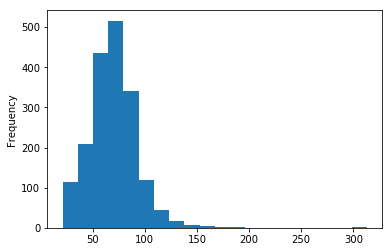

In [18]:
df = getTrainDataset()
df['Lot Frontage'].plot.hist(bins=20)
plt.show()


Previous graph shows that we have some outliers in this columns, and most of the datapoints are centered on a value around 60.

The approach we can choose to handle null values in this column is to replace them by the mean value of the column, without the outliers and null values. See below the new histogram and the mean value calculated. This value will be used to replace null values in that column.

Mean value calculated with the reduced dataset: 68.79


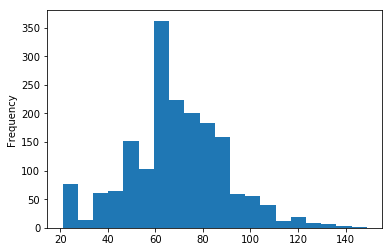

In [19]:
outliers_filter = np.logical_and(df['Lot Frontage'] < 150, df['Lot Frontage'] > 0)

df['Lot Frontage'][outliers_filter].plot.hist(bins=20)
mean_value = df['Lot Frontage'][outliers_filter].mean()
print("Mean value calculated with the reduced dataset: {:.2f}".format(mean_value))


In [20]:
# Replace null values in the global dataset (train and test) with the mean value calculated before with the train test
data_df['Lot Frontage'] = data_df['Lot Frontage'].fillna(int(mean_value))

# Rebuild our global data_df variable using train_df_list[400] as new Train dataset
#data_df = pd.concat([df.copy(), getTestDataset().copy()], sort=False, ignore_index=True)


print("Number of null value in Train dataframe:", df.isnull().sum().sum())
print("Global dataframe size:", data_df.shape)
print("Good :-)")


Number of null value in Train dataframe: 394
Global dataframe size: (2709, 88)
Good :-)


Fine. Our Train dataset has now 0 null values. It's time now to perform feature encoding and feature engineering 

Before that, let's classify columns in four categories using the documentation provided with the dataset. Goal is to build 4 list of column names, one for each type: continuous, nominal, ordinal and discrete.

In [21]:
# Continuous variables
continuous_column = [
    '1st Flr SF', '2nd Flr SF', 'Lot Area', 'Mas Vnr Area', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF', 'Lot Frontage',
    'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', '3Ssn Porch', 'Open Porch SF', 'Wood Deck SF', 'Pool Area', 'Screen Porch', 'Misc Val', 'Enclosed Porch',
]

# Nominal variables - no possible ordering
nominal_column = [
    'MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Exterior 1st',
    'Exterior 2nd', 'Roof Matl', 'Roof Style', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Sale Condition', 'Sale Type', 'Street',
]

# Ordinal variables - you can order the categories
ordinal_column =[
    'Lot Shape', 'Land Slope', 'Overall Cond', 'Overall Qual', 'Exter Cond', 'Exter Qual', 'Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1',
    'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Finish', 'Garage Cond', 'Garage Qual', 'Paved Drive', 'Utilities'
]

# Discrete variables - categories are integer values
discrete_column = [
    'Year Built', 'Year Remod/Add', 'Mo Sold', 'Yr Sold', 'Full Bath', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces',
    'Garage Yr Blt', 'Garage Cars', 'Bedroom AbvGr', 'Kitchen AbvGr',
]


y_column = [
 'SalePrice',
]

# This trick should return the columns we've added to our dataset, number of these should be 12
unclassified_columns = set(data_df.columns.values.tolist()) - set(continuous_column) - set(nominal_column) - set(ordinal_column) - set(discrete_column) - set(y_column) 
print("Number of column not classified:",len(unclassified_columns))
print("Column names:",','.join(sorted(unclassified_columns)))
print("Global Dataframe size:", data_df.shape)


Number of column not classified: 13
Column names: Alley Exists,Alley Type_Grvl,Alley Type_Pave,Fence Exists,Fireplace Exists,Fireplace Quality,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,PID,Pool QC Exists
Global Dataframe size: (2709, 88)


## Feature encoding

### Ordinal columns

Let's consider first the ordinal columns, and convert them to numerical column for better model fitting, using our previous encodeOrdinalColumnToNumeric() function.

Looking at some of those columns, we must perform some more data cleaning before converting them.

#### Basement

Basement information are contained in 8 Bsmt* columns plus 'Total Bsmt SF'. 5 of them are ordinal:
* Bsmt Cond
* Bsmt Exposure
* Bsmt Qual
* BsmtFin Type 1
* BsmtFin Type 2

We will encode them as numerical column, which will remove null values, and build another column which states if the house has a basement. This new column will be based on the 'Total Bsml SF' column and will be 'one-hot' encoded.

Before that, I do a small control to ensure that Total Bsmt SF = Bsmt 1 SF + Bsmt 2 SF + Basmt Unfinished SF

In [22]:
temp_df = data_df[['Total Bsmt SF','Bsmt Unf SF','Bsmt Cond','Bsmt Exposure','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2','BsmtFin SF 1','BsmtFin SF 2']].copy()
temp_df['Sum'] = data_df['BsmtFin SF 1'] + data_df['BsmtFin SF 2'] + data_df['Bsmt Unf SF']
temp_df['Equal ?'] = temp_df['Sum'] == temp_df['Total Bsmt SF']
print(temp_df['Equal ?'].value_counts())
print("No False result, equality between cells about Square Feet is respected")

True    2709
Name: Equal ?, dtype: int64
No False result, equality between cells about Square Feet is respected


One more thing is the ordinal value 'Unf' in 'BsmtFin Type 1' and 'BsmFin Type 2'. This value does not evaluate the quality of the basement but the fact that it is not finished.

I will then create two new columns 'Bsmt Type 1 Exists' and 'Bsmt Type 2 Exists' with 1 or 0 value. Then, on the BsmtFin Type 1 & 2 column, I will replace 'Unf' values with 0.

In [23]:
# Create Basement Exists, Bsmt Type 1 & 2 Unf and one encode them
# Be caareful to not flag them as to be deleted
whereClauseReplacement('Total Bsmt SF', data_df['Total Bsmt SF'] == 0, true_value=0, false_value=1, drop_original_column=False)
whereClauseReplacement('BsmtFin Type 1', data_df['BsmtFin Type 1'] == 'Unf', true_value=0, false_value=1, drop_original_column=False)
whereClauseReplacement('BsmtFin Type 2', data_df['BsmtFin Type 2'] == 'Unf', true_value=0, false_value=1, drop_original_column=False)

# Convert ordinal Bsmt columns to numerical
mapping = {
    'Bsmt Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Bsmt Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Bsmt Exposure': { 'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1 },
    'BsmtFin Type 1': { 'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0 },
    'BsmtFin Type 2': { 'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0 },
}
for c in mapping:
    encodeLiteralToNumericValues(column=c, mapping=mapping[c], replacena=0)


Doing a binary replacement on column Total Bsmt SF
  New column name: Total Bsmt SF Exists
Doing a binary replacement on column BsmtFin Type 1
  New column name: BsmtFin Type 1 Exists
Doing a binary replacement on column BsmtFin Type 2
  New column name: BsmtFin Type 2 Exists
Encoding column Bsmt Qual to numerical values
  Column successfully encoded with numerical values
  Values in column: [4. 3. 5. 2. 1. 0.]
Encoding column Bsmt Cond to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 4. 2. 5. 1. 0.]
Encoding column Bsmt Exposure to numerical values
  Column successfully encoded with numerical values
  Values in column: [1. 3. 2. 4. 0.]
Encoding column BsmtFin Type 1 to numerical values
  Column successfully encoded with numerical values
  Values in column: [5. 0. 2. 1. 3. 4.]
Encoding column BsmtFin Type 2 to numerical values
  Column successfully encoded with numerical values
  Values in column: [0. 1. 3. 2. 4. 5.]


#### Utilities

The 'Utilities' ordinal column is a bit special as all but three entries are identical. This let me think that this information mignt not be usefull to fit a model.

Instead of dropping this columns, I would prefer to drop the three lines that are different from the rest. This will avoid having outliers in our train dataset for house sale prices as these three houses do not have all the basic utilities. Furthermode, a look at the test dataset shows that we do have only houses in this 500 lines dataset with all the Utilities. Loosing information on how much incomplete utilities can modify the sale price is useless here.

In [24]:
print("Values in 'Utilities' column of the test dataset are unique and equal to 'AllPub':")
print(getTestDataset()['Utilities'].value_counts())
print("We can drop the 'Utilities' column from the train dataset and remove the three houses with Utiliies != 'AllPub'")

# Remove the three houses that do not have all the utilities
# DO IT ON THE TRAIN DATASET ONLY
train_df=getTrainDataset().copy()
train_df=train_df[train_df['Utilities'] == 'AllPub']

# Rebuild the global dataset
concatTrainAndTestDataset(train_df, getTestDataset())

addColumnToDropList(['Utilities'])

print("Size of the global Dataset:", data_df.shape)



Values in 'Utilities' column of the test dataset are unique and equal to 'AllPub':
AllPub    500
Name: Utilities, dtype: int64
We can drop the 'Utilities' column from the train dataset and remove the three houses with Utiliies != 'AllPub'
Rebuild global dataset with train_df (2207, 91) and test_df (500, 91)
Columns flaged as 'to be removed': Utilities
Size of the global Dataset: (2707, 91)


#### Garage

Garage is nearly the same as for Basement. Some of the houses do not have garage.

Best way shoulod be to create a new column 'Has Garage' and convert ordinal Garage columns to numerical values.



In [25]:
# Create Garage Area Exists and one encode it (do not forget test_df)
whereClauseReplacement('Garage Area', data_df['Garage Area'] == 0, true_value=0, false_value=1, drop_original_column=False)

# Convert ordinal Garage columns to numerical
mapping = {
    'Garage Finish': {'Fin': 3, 'RFn': 2, 'Unf': 1 },
    'Garage Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Garage Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
}

for c in mapping:
    encodeLiteralToNumericValues(column=c, mapping=mapping[c], replacena=0)

Doing a binary replacement on column Garage Area
  New column name: Garage Area Exists
Encoding column Garage Finish to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 1. 2. 0.]
Encoding column Garage Qual to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 2. 4. 5. 1. 0.]
Encoding column Garage Cond to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 2. 4. 5. 1. 0.]


#### Remaining ordinal columns

The remaining ordinal columns are simply re-encoded using numerical values, except for 'Overall Cond' and 'Overall Qual' as those two columns are already ordinal ones with numeric values.


In [26]:
mapping = {
    'Electrical': { 'SBrkr': 5, 'FuseA': 4,'FuseF': 3,'FuseP': 2, 'Mix': 1 },
    'Exter Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Exter Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Functional': { 'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 0 },
    'Heating QC': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Kitchen Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Land Slope': { 'Gtl': 3, 'Mod': 2, 'Sev': 1 },
    'Lot Shape': { 'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1 },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1 },
}

for c in mapping:
    encodeLiteralToNumericValues(column=c, mapping=mapping[c], replacena=0)


Encoding column Electrical to numerical values
  Column successfully encoded with numerical values
  Values in column: [5 3 4 2 1]
Encoding column Exter Cond to numerical values
  Column successfully encoded with numerical values
  Values in column: [3 4 2 5 1]
Encoding column Exter Qual to numerical values
  Column successfully encoded with numerical values
  Values in column: [4 3 2 5]
Encoding column Functional to numerical values
  Column successfully encoded with numerical values
  Values in column: [8 5 4 6 7 3 2 0]
Encoding column Heating QC to numerical values
  Column successfully encoded with numerical values
  Values in column: [5 3 2 4 1]
Encoding column Kitchen Qual to numerical values
  Column successfully encoded with numerical values
  Values in column: [4 3 5 2 1]
Encoding column Land Slope to numerical values
  Column successfully encoded with numerical values
  Values in column: [3 2 1]
Encoding column Lot Shape to numerical values
  Column successfully encoded with 

#### Clean up

Now that all our ordinal column have been transformed and/or re-encoded, let's drop and one-hot encode the columns and check that our ordinal columns of our dataframe are all dtype = int64

In [27]:
dropAndEncode()

# Remove 'Utilities' column from the ordinal_column list
if 'Utilities' in ordinal_column:
    ordinal_column.remove('Utilities')

print("dtypes of the ordinal columns:")
data_df[ordinal_column].dtypes


Size of the dataframe BEFORE applying one-hot encoding: (2707, 92)
Size of the dataframe AFTER applying one-hot encoding: (2707, 92)
  Drop columns: {'Utilities'}
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2707, 91)
dtypes of the ordinal columns:


Lot Shape         int64
Land Slope        int64
Overall Cond      int64
Overall Qual      int64
Exter Cond        int64
Exter Qual        int64
Bsmt Cond         int64
Bsmt Qual         int64
Bsmt Exposure     int64
BsmtFin Type 1    int64
BsmtFin Type 2    int64
Heating QC        int64
Electrical        int64
Kitchen Qual      int64
Functional        int64
Garage Finish     int64
Garage Cond       int64
Garage Qual       int64
Paved Drive       int64
dtype: object

### Nominal columns

Regarding nominal columns, option is very simple. We must perform one-hot encoding on each to get numeric columns.

In [28]:
addColumnToOneHotEncoding(nominal_column)
dropAndEncode()


Columns flaged as 'to be one-hot encoded': Street,Exterior 1st,Land Contour,Exterior 2nd,Bldg Type,Condition 1,Condition 2,Roof Matl,Roof Style,Sale Condition,Neighborhood,Lot Config,Heating,Central Air,Foundation,MS Zoning,Garage Type,Sale Type,House Style,MS SubClass,Mas Vnr Type
Size of the dataframe BEFORE applying one-hot encoding: (2707, 91)
  Do 'one-hot' encoding on: {'Street', 'Exterior 1st', 'Land Contour', 'Exterior 2nd', 'Bldg Type', 'Condition 1', 'Condition 2', 'Roof Matl', 'Roof Style', 'Sale Condition', 'Neighborhood', 'Lot Config', 'Heating', 'Central Air', 'Foundation', 'MS Zoning', 'Garage Type', 'Sale Type', 'House Style', 'MS SubClass', 'Mas Vnr Type'}
Size of the dataframe AFTER applying one-hot encoding: (2707, 245)
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2707, 245)


In [29]:
print("Size of the current dataframe:", data_df.shape)


Size of the current dataframe: (2707, 245)


At that point, number of features of our dataset has increased to 242 element (243 minus our result vector)

Good :-)

### Discrete columns

Not so much to do with the discrete columns as they are globaly clean (they looks like ordinal columns) except for columns concerning dates.


In [30]:
for c in sorted(discrete_column):
    print(c,":\t",sorted(data_df[c].unique()))

Bedroom AbvGr :	 [0, 1, 2, 3, 4, 5, 6]
Bsmt Full Bath :	 [0.0, 1.0, 2.0]
Bsmt Half Bath :	 [0.0, 1.0, 2.0]
Fireplaces :	 [0, 1, 2, 3, 4]
Full Bath :	 [0, 1, 2, 3, 4]
Garage Cars :	 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Garage Yr Blt :	 [1895.0, 1896.0, 1900.0, 1906.0, 1908.0, 1910.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 20

We have five interesting columns here:
* Mo Sold: Month in the year when the house has been sold
* Yr Sold: Year when the house has been sold
* Garage Yr Blt: The year when the garage has been built
* Year Built: Year of construction of the houses
* Year Remod/Add: Year when the house has been remodeled (same as construction date if no remodeling or additions)



#### Garage Yr Blt, Year Built and Year Remod/Add

##### Clean inconsistencies

First of all, we must check if all the dates between those columns are coherent between them, and against the Yr Sold value:
* Do we have houses sold before being built ?
* Do we have houses remoded before being built ?
* Do we have garage built after the house has been sold ?

Secondly, when this clean up is complete, we can use those columns to create new nominal one:

* Does the house have been sold as a new one ?
* Does the house have beem remoded ?
* Does the Garage have been built at the same time of the house ?


Let's define some boolean arrays to seek incoherence in dates.

> Note: This cleaning is done accross the whole dataset (Train + Test) as corrected values for each cell is taken with the same row of the cell.

In [31]:
build=data_df['Year Built']
renov=data_df['Year Remod/Add']
sold=data_df['Yr Sold']
garage=data_df['Garage Yr Blt']

# Build columns with year delta
data_df['house sold age'] = sold-build # Year between build and sold
data_df['house remoded age'] = renov-build # Year between remoded and build
data_df['garage delay'] = garage-build # Yesar between garage build and house build

# Add those temprorary columns to deletion list
addColumnToDropList(['house sold age', 'house remoded age', 'garage delay'])

Columns flaged as 'to be removed': house sold age,garage delay,house remoded age


Draw histogram of the three previously created columns.

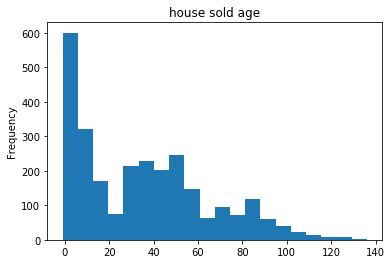

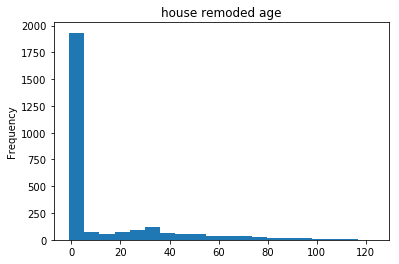

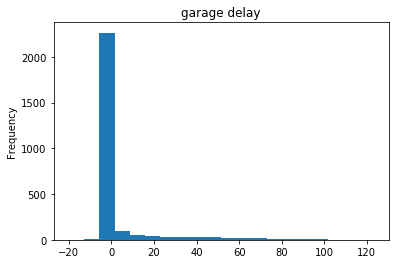

In [32]:
for c in ['house sold age', 'house remoded age', 'garage delay']:
    data_df[c].plot.hist(bins=20)
    plt.title(c)
    plt.show()


Previous histogram shows that most of the garage have been build the same year as the house itself, and most of the houses have never been remoded.

Using those columns, we will seek for inconsistencies:

In [33]:
# Seek for inconsistencies

# ['house sold age']    < 0   # house sold before being built
# ['house remoded age'] < 0   # House remoded before being built
# ['garage delay']      < 0   # Garage built before the house

for c in ['house sold age', 'house remoded age', 'garage delay']:
    # Get boolean array of inconsistent rows
    filter=data_df[c] < 0
    print("Number of insistencies found for {}: {}".format(c,data_df[filter].shape[0]))
    print(data_df[filter][['Year Built', 'Yr Sold', 'Year Remod/Add',  'Garage Yr Blt', c]])


Number of insistencies found for house sold age: 1
    Year Built  Yr Sold  Year Remod/Add  Garage Yr Blt  house sold age
66        2008     2007            2009         2008.0              -1
Number of insistencies found for house remoded age: 1
      Year Built  Yr Sold  Year Remod/Add  Garage Yr Blt  house remoded age
2389        2002     2009            2001         2002.0                 -1
Number of insistencies found for garage delay: 17
      Year Built  Yr Sold  Year Remod/Add  Garage Yr Blt  garage delay
124         1963     2008            1963         1962.0          -1.0
137         1935     2009            1950         1926.0          -9.0
293         1978     2009            1978         1960.0         -18.0
370         1927     2008            1950         1920.0          -7.0
935         1959     2006            1959         1954.0          -5.0
1157        1935     2009            1998         1920.0         -15.0
1190        1959     2010            1959         1956

Not so much inconsistencies. The quicker solution is to replace invalid dates by a more coherent one:
* When house is sold before being built, replace sold year by built year
* When house is remoded before being built, replace remod year by sold year
* When garage is built before the house, replace the garage built year by the house built year

To do so, the trick is very simple. Substract the delta identified to the incoherent value. For example, set 'Yr Sold' = 'Yr Sold' - 'house sold age'


In [34]:
for c, wrong_c in zip(['house sold age', 'house remoded age', 'garage delay'], ['Yr Sold', 'Year Remod/Add',  'Garage Yr Blt']):
    # Get boolean array of inconsistent rows
    filter=data_df[c] < 0
    print("Modify inconsistencies for {}".format(c))
    for i in data_df[filter].index:
        new_value = str(data_df.loc[i,wrong_c] - data_df.loc[i,c])
        data_df.at[i,wrong_c]=new_value

# Re-check inconsistencies after those modifications
# If everything is OK, we must not obtain any row
build=data_df['Year Built']
renov=data_df['Year Remod/Add']
sold=data_df['Yr Sold']
garage=data_df['Garage Yr Blt']
# Build columns with year delta
data_df['house sold age'] = sold-build # Year between build and sold
data_df['house remoded age'] = renov-build # Year between remoded and build
data_df['garage delay'] = garage-build # Yesar between garage build and house build        

for c in ['house sold age', 'house remoded age', 'garage delay']:
    # Get boolean array of inconsistent rows
    filter=data_df[c] < 0
    print("Number of inconsistencies found for {}: {}".format(c,data_df[filter].shape[0]))
    print(data_df[filter][['Year Built', 'Yr Sold', 'Year Remod/Add',  'Garage Yr Blt', c]])

Modify inconsistencies for house sold age
Modify inconsistencies for house remoded age
Modify inconsistencies for garage delay
Number of inconsistencies found for house sold age: 0
Empty DataFrame
Columns: [Year Built, Yr Sold, Year Remod/Add, Garage Yr Blt, house sold age]
Index: []
Number of inconsistencies found for house remoded age: 0
Empty DataFrame
Columns: [Year Built, Yr Sold, Year Remod/Add, Garage Yr Blt, house remoded age]
Index: []
Number of inconsistencies found for garage delay: 0
Empty DataFrame
Columns: [Year Built, Yr Sold, Year Remod/Add, Garage Yr Blt, garage delay]
Index: []


##### New house nominal column

To improve our feature, we can create a new nominal column that will have 0/1 values in it, 1 meaning that the house has been solded as a new house ('Year Sold' - 'Year Build' == 0). We can use the proviously built boolean array data_df['house sold age'] to identify new house. If equal to 0, then the house has been solded as a new one.



In [35]:
# Add a empty column
data_df['House New'] = np.nan

# and use our function to build a nominal column
whereClauseReplacement('House New', data_df['house sold age'] == 0, true_value=1, false_value=0, suffix='', drop_original_column=False)


Doing a binary replacement on column House New
  New column name: House New


#### Mo Sold

Looking at the distribution of the values of the 'Mo Sold' column in the dataset demonstrates that the summer monthes gets more sales, and at the same time, correlation between 'Mo Sold' and 'SalePrice' is very low.

Let's keep this column as is.

Correlation between 'Mo Sold' and 'SalePrice': 0.02


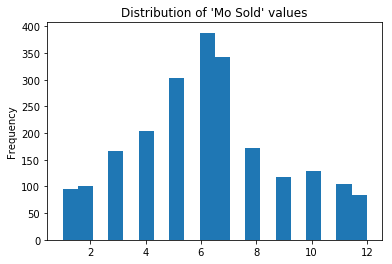

In [36]:
print("Correlation between 'Mo Sold' and 'SalePrice': {:.2f}".format(getTrainDataset()['Mo Sold'].corr(train_df['SalePrice'])))
getTrainDataset()['Mo Sold'].plot.hist(bins=20)
plt.title("Distribution of 'Mo Sold' values")
plt.show()

#### Yr Sold

Firstly, I though this column won't be relevant as the number of unique values is 5, years from 2006 to 2010.

But, one thing that might be interesting is that 2008 is the 'Subprime crisis' start, with huge effect on the real estate market in the subsequent years

If we look at the number of sales over the five years, we can clearly see a drop of the number of sales by 50% in 2010.


In [37]:
getTrainDataset()[['Yr Sold','Mo Sold']].groupby('Yr Sold').count()

,Mo Sold
Yr Sold,
2006,474
2007,534
2008,475
2009,467
2010,257


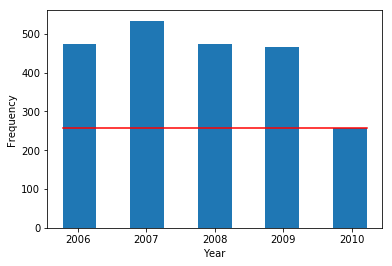

In [38]:
getTrainDataset()['Yr Sold'].plot.hist(bins=9)
plt.xticks([2006.2,2007.1,2008,2008.9,2009.8],labels=['2006','2007','2008','2009','2010'])
plt.xlabel("Year")
plt.plot((2006,2010),(257,257), c='red')
plt.show()

Will this have an impact on our model fitting process ? I dont know.

For the moment, let it that way.


#### Last check on Discrete columns

It's now time to call our dropAndEncode() function and check the dataframe for null cell values.

In [39]:
dropAndEncode()

# Is there any null values, except in the 'SalePrice' columns ?
data_df.drop(['SalePrice'], axis=1).isnull().sum().sort_values(ascending=False).head(5)

Size of the dataframe BEFORE applying one-hot encoding: (2707, 249)
Size of the dataframe AFTER applying one-hot encoding: (2707, 249)
  Drop columns: {'house sold age', 'garage delay', 'house remoded age'}
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2707, 246)


Garage Yr Blt           21
Mas Vnr Area             3
House New                0
Exterior 1st_HdBoard     0
Land Contour_Lvl         0
dtype: int64

Ok. We remain with two columns with null cells values: 'Garage Yr Blt' and 'Mas Vnr Area'. The second one is a continuous value column and will be handled below in this Notebook.

The 'Garage Yr Blt' column is one of the discrete column we've managed above. Why do we have null values ?
Simply because when we've built our filter to seek for inconsistencies, null cell values where missed.

Looking more precisely to those null cells values, we will find that they are all contained in the Test dataset:


In [40]:
getTestDataset()[getTestDataset()['Garage Yr Blt'].isnull()][['Yr Sold', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']]

,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt
2213,2009,1900,1950,NaN
2265,2006,1970,1970,NaN
2269,2007,1946,1950,NaN
2270,2010,1968,1968,NaN
2288,2008,1925,1950,NaN
2308,2007,1955,1955,NaN
2309,2006,1951,1951,NaN
2391,2006,1941,1950,NaN
2406,2008,1961,1961,NaN
2419,2009,1959,1959,NaN


My proposal is to replace null cells values with the corresponding 'Year Builf' of the concerned house.

> Note: In real life work, we should have to do this on the fourth column as we can not know by advance weither our test set will contains
null cells. Let's keep thing simple here for this exercise, this Notebook will be enough long to read ;-)

In [41]:
# Get the index of lines with null values
line_index=data_df[data_df['Garage Yr Blt'].isnull()].index


In [42]:

# Replace null 'Garage Yr Blt' value with 'Year Built' value
for i in line_index:
    new_value = str(data_df.loc[i,'Year Built'])
    print("Setting 'Garage Yr Blt' for line {} to: {}".format(i,new_value))
    data_df.at[i,'Garage Yr Blt']=new_value

# Check the result
data_df.iloc[line_index][['Yr Sold', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']]


Setting 'Garage Yr Blt' for line 2213 to: 1900
Setting 'Garage Yr Blt' for line 2265 to: 1970
Setting 'Garage Yr Blt' for line 2269 to: 1946
Setting 'Garage Yr Blt' for line 2270 to: 1968
Setting 'Garage Yr Blt' for line 2288 to: 1925
Setting 'Garage Yr Blt' for line 2308 to: 1955
Setting 'Garage Yr Blt' for line 2309 to: 1951
Setting 'Garage Yr Blt' for line 2391 to: 1941
Setting 'Garage Yr Blt' for line 2406 to: 1961
Setting 'Garage Yr Blt' for line 2419 to: 1959
Setting 'Garage Yr Blt' for line 2440 to: 1985
Setting 'Garage Yr Blt' for line 2444 to: 1970
Setting 'Garage Yr Blt' for line 2508 to: 1926
Setting 'Garage Yr Blt' for line 2510 to: 1919
Setting 'Garage Yr Blt' for line 2528 to: 1955
Setting 'Garage Yr Blt' for line 2544 to: 1920
Setting 'Garage Yr Blt' for line 2655 to: 1967
Setting 'Garage Yr Blt' for line 2660 to: 1949
Setting 'Garage Yr Blt' for line 2664 to: 1872
Setting 'Garage Yr Blt' for line 2672 to: 1941
Setting 'Garage Yr Blt' for line 2689 to: 1910


,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt
2213,2009,1900,1950,1900.0
2265,2006,1970,1970,1970.0
2269,2007,1946,1950,1946.0
2270,2010,1968,1968,1968.0
2288,2008,1925,1950,1925.0
2308,2007,1955,1955,1955.0
2309,2006,1951,1951,1951.0
2391,2006,1941,1950,1941.0
2406,2008,1961,1961,1961.0
2419,2009,1959,1959,1959.0


### That's all folks with Discrete columns :-)

Cleaning process is terminated for those Discrete columns, no more null cells in the Dataframe (except for the continuous column that will be handled later
in this Notebook)

In [43]:
# Is there any null values, except in the 'SalePrice' and 'Mas Vnr Area' columns ?
null_count=data_df.drop(['SalePrice', 'Mas Vnr Area'], axis=1).isnull().sum().sort_values(ascending=False).sum()
if(null_count == 0):
    print("No null values found in the Dataframe. Good :-)")
else:
    raise SystemExit("WARNING: Found null cells in Dataframe. Aborting Notebook execution")


No null values found in the Dataframe. Good :-)


## Feature engineering

It's time now to do some feature engineering on the remaining columns: The continuous one.

Before that, there's something to do with a few number of the Discrete column. The one that contains year values.

### Reduce amplitude of year column

Year column contains year values, that's an evidence. Those values are stored as number, which is fine to fit model. The problem is that creates high values and we should reduce the amplitude of those values.

To reduce the amplitude of the year values, let's substract the max year found in 'Year Sold' column (2010) with values in those columns. This way, year column will be converted with age column, which is in my opinion a better scale.

Be carefull that we have to take the np.abs() value of the substraction to have a positive aging.

This will do a sort of remap of the values and simulate a nominal column

> Question: Should I create intervals such as 0 < year < 10  => Category1 in real life ? 

> Note: This cell can not be ran multiple times as is after the first run. I've added a test on the np.max('Year Sold') value. If it is below 2000,
we can conclude that columns have been remaped, we then avoid doing the job again (it will lead us to incoherent values)


> Note: The max year found in 'Year Sold' must be the youngest one in the whole dataset,  thanks to the cleaning we've done earlier.

Max year found: 2010


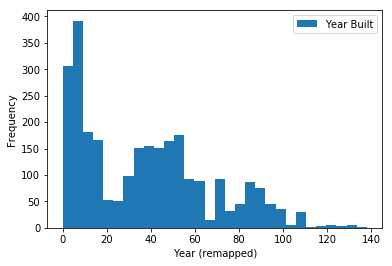

In [44]:
year_column = ['Year Built', 'Yr Sold', 'Year Remod/Add',  'Garage Yr Blt']

# Get the max date from the 'Year Sold' column
current_year=np.max(getTrainDataset()['Yr Sold'])
print("Max year found:", current_year)

# This trick to be able to rerun this cell multiple times
if current_year < 2000:
    print("Year columns have already been remapped. Skipping process")
else:

    # Substract this date to year columns values
    for c in year_column:
        data_df[c] = np.abs(data_df[c] - current_year)
        pass

# Display histogram to check new year built values
data_df[['Year Built']].plot.hist(bins=30)
plt.xlabel('Year (remapped)')
plt.show()


### Continuous columns

At first, let's draw scatter plots for our continous columns against the SalePrice (using train dataset only) in order to decide what to do with them.
Before drawing the plots, I will remove null values and outliers from those continuous columns.

Why removing null ? Because some of the continuous columns contains 0 when not applicable. For example, houses without a pool does have 0 square-feet in the Pool Area column. As we've already used those null values to do one-hot encoding on it, we have the information of havong pool or not to detect any correlation. What we are now seeking is how the size of the pool can inluence the house sale price.


#### Draw scatter plot

To simplify the work, I will define a function that will draw a scatter plot from a continuous column, first removing lines with value == 0, and secondly remove the outliers. This will help to decide what to do with those columns.



Drawing graphs 5 x 4 (number of column = 19)


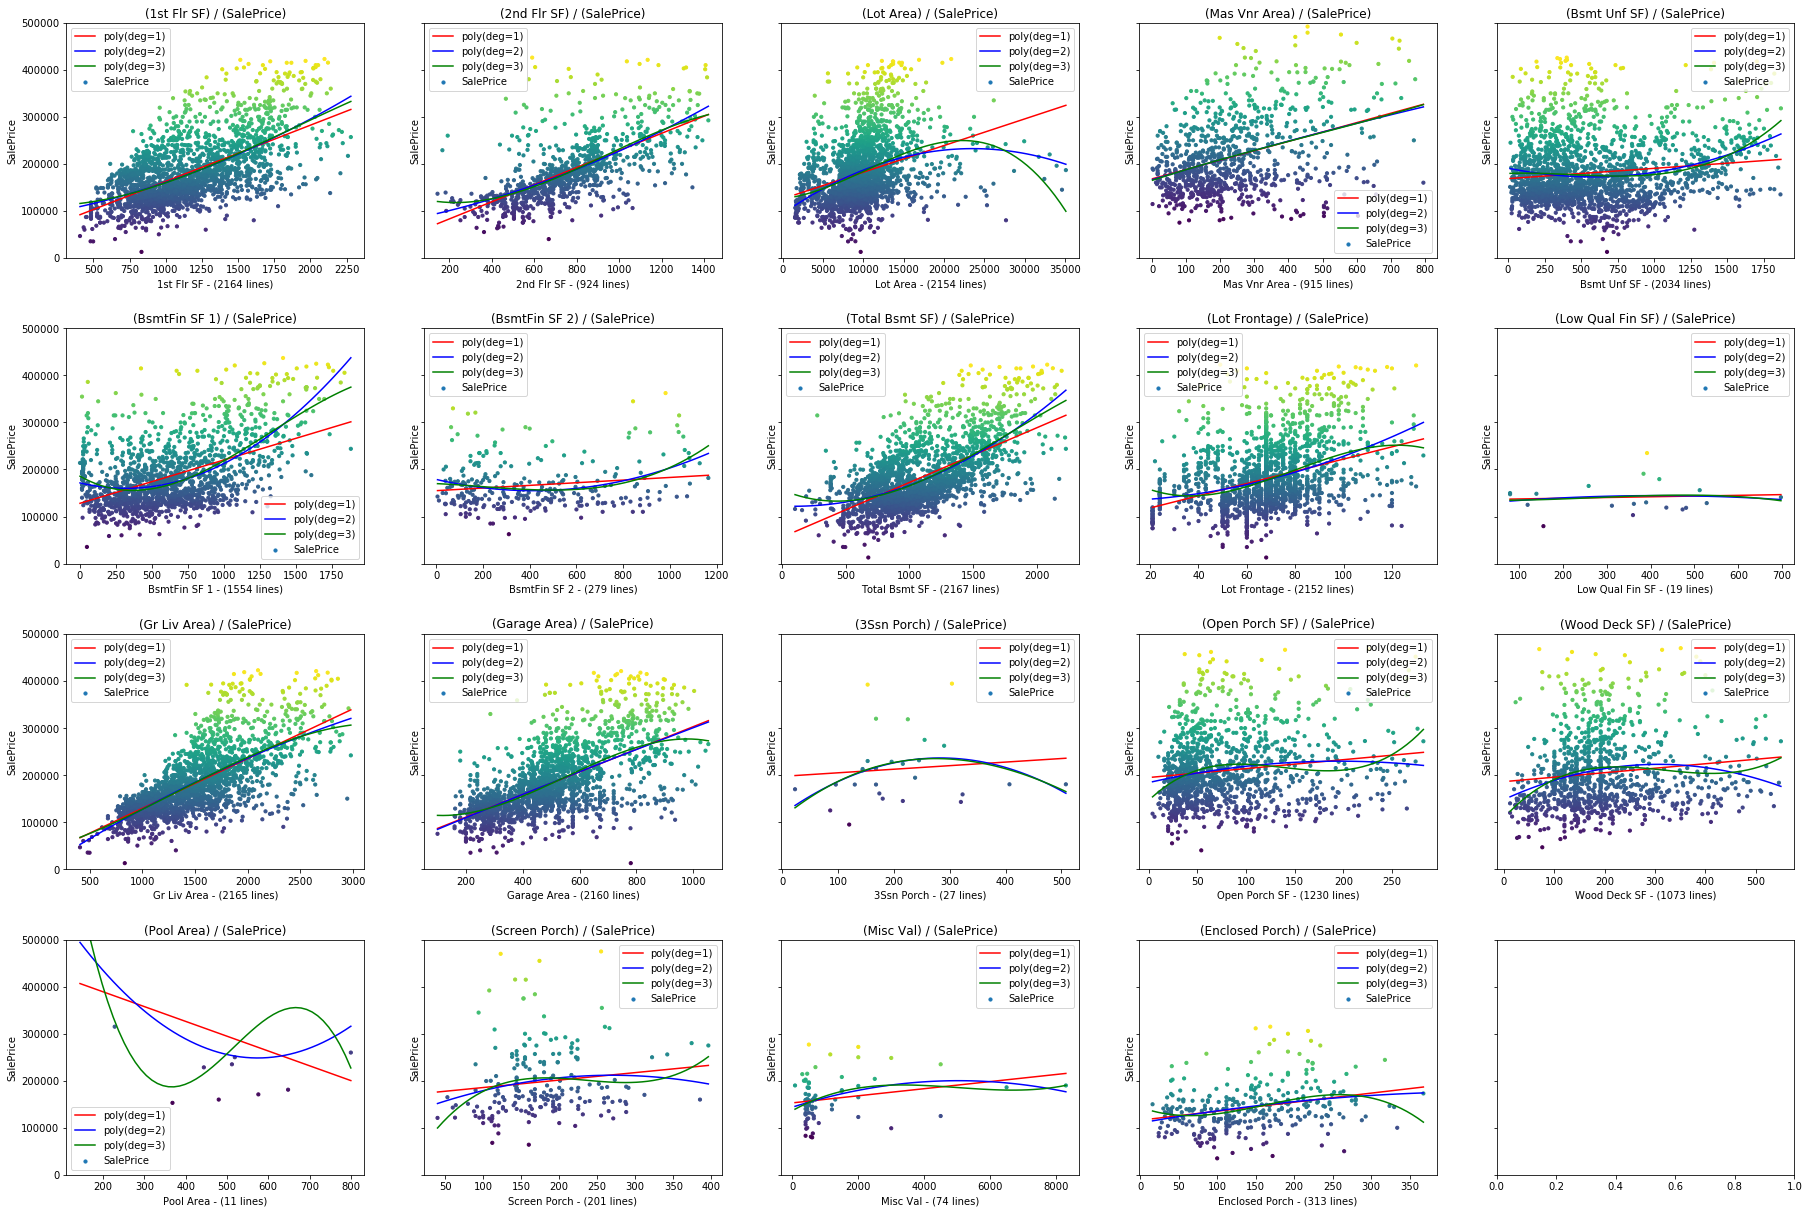

In [45]:
from scipy.stats import zscore 

def drawScatterPlot(df, x_columns=[], y_column='SalePrice', z_factor=2, graph_per_line=5, figsize=(25,15), ylim=[0,500000], polyfit_deg=0):
    '''
    Function that draws a scatter plot from the dataframe passed as first parameter, using columns passed as
    second parameter (default to 'SalePrice').
    Before plotting the result, this function will remove lines where x values are == 0, and then
    remove outliers on both columns
    '''

    nb_columns=len(x_columns)
    nb_line=int(((nb_columns-1)/graph_per_line)+1)
    
    print("Drawing graphs {} x {} (number of column = {})".format(graph_per_line, nb_line, nb_columns))
    
    graph_col=0
    graph_line=0

    
    # Create Figure and Axes instances
    if(nb_line > 1):
        fig, axs = plt.subplots(nb_line, graph_per_line, sharey=True, figsize=figsize)
    else:
        fig, axs = plt.subplots(1, graph_per_line, figsize=figsize)
        

    for c in x_columns:
    
        # Remove 0 values
        temp_df = df[df[c]!=0][[c, y_column]]
    
        # Calculate zscore of each cells of the columns passed as parameter
        #zscore_values = zscore(temp_df[[c, y_column]])
        zscore_values = zscore(temp_df[[c,y_column]])
    
        # Build an arraqy of boolen where True = np.abs(zscore) is lower than factor
        zscore_bool = np.abs(zscore_values) < z_factor
    
        # Use the all(axis=1) function on zscore_bool array to get a 1-row-array containing boolean values
        # where True means that at least one cell of the zscore_bool corresponding line is True
        # This 1-row-array will be used to filter the temp dataframe
        temp_df = temp_df[zscore_bool.all(axis=1)]
    
        # Make plot, set axes labels
        if(nb_line>1):
            ax=axs[graph_line, graph_col]
        else:
            ax=axs[graph_col]

        x=temp_df[c]
        y=temp_df[y_column]
        
        ax.scatter(x, y, s=10, c=y, cmap='viridis')
        ax.set_ylabel(y_column)
        ax.set_xlabel("{} - ({} lines)".format(c, x.shape[0]))
        ax.set_title("({}) / ({})".format(c,y_column))
        ax.set_ylim(ylim)
        
        
        # Draw polyfit from deg=1 to deg=polyfit_deg
        # Do nothing if polyfit_deg == 0 or > 3
        if polyfit_deg > 0 and polyfit_deg < 4:
            colors=['r','b','g']
        
            
            for i,color in enumerate(colors[:3]):
                coef=np.polyfit(x,y,deg=i+1)
                x_values=np.linspace(x.min(), x.max())
                y_values=np.polyval(coef, x_values)
                ax.plot(x_values, y_values, label='poly(deg={})'.format(i+1), c=color)
                ax.legend()
        
        # increment axes index
        graph_col+=1
        if(graph_col > graph_per_line-1):
            graph_col=0
            graph_line+=1

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.3)
    # display graph
    plt.show()


drawScatterPlot(getTrainDataset(), continuous_column, graph_per_line=5, figsize=(30,20), z_factor=3, polyfit_deg=3)


So, looking at the previous scatter plots, here what I decide to do for each columns

#### '1st Flr SF', '2nd Flr SF' and 'Gr Liv Area'
These three columns are correlated as 'Gr Liv Area' == '1st Flr SF' + '2nd Flr SF' except for 30 houses in the train set. Let's consider that for those 30 houses, extra square feet found are used by maybe a third floor, or anything that is not categorized in our continuous feature.

So, what to do with those correlated features ? 

Well, one thing interesting here is the fact that '2nd Flr SF' and extra Square Feet give us two important informations: Does the house has a second floor, and does the house has an *extra* floor.

What I would suggest is to build two new nominal column '2nd Flr Exists' and 'Extra Flr Exists' and drop the '2nd Flr SF' continuous column. This will remove correlation without loosing too much information.



In [46]:
# Calculate missing SF
data_df['Extra Flr SF'] = data_df['Gr Liv Area'] - data_df['1st Flr SF'] - data_df['2nd Flr SF']

# Create an 'Extra Flr Exists' nominal column
whereClauseReplacement('Extra Flr SF', data_df['Extra Flr SF'] == 0)
# Display number of house with an extra floor
data_df[['Extra Flr SF Exists', 'Gr Liv Area']].groupby('Extra Flr SF Exists').count().rename({'Gr Liv Area': 'count'}, axis=1)


Doing a binary replacement on column Extra Flr SF
  New column name: Extra Flr SF Exists
  Drop original column
Columns flaged as 'to be removed': Extra Flr SF


,count
Extra Flr SF Exists,
0,2676
1,31


In [47]:
# We do the same for the '2nd Flr Exists'
whereClauseReplacement('2nd Flr SF', data_df['2nd Flr SF'] == 0)
# Display number of house with an extra floor
data_df[['2nd Flr SF Exists', 'Gr Liv Area']].groupby('2nd Flr SF Exists').count().rename({'Gr Liv Area': 'count'}, axis=1)




Doing a binary replacement on column 2nd Flr SF
  New column name: 2nd Flr SF Exists
  Drop original column
Columns flaged as 'to be removed': 2nd Flr SF,Extra Flr SF


,count
2nd Flr SF Exists,
0,1537
1,1170


#### 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2' and 'Total Bsmt SF'

Same as above, there is a linear correlation between those 4 columns (we've already checked that previously in this Notebook).

But, there is a small difference here. We've previously built nominal columns that determines if the house has a basement type 1, tpye 2 or both. So, the only thing to do here is to drop the 'BsmtFin SF 2' column


In [48]:
addColumnToDropList(['BsmtFin SF 2'])

Columns flaged as 'to be removed': 2nd Flr SF,BsmtFin SF 2,Extra Flr SF


#### 'Low Qual Fin SF', '3Ssn Porch', 'Misc Val', 'Enclosed Porch','Pool Area' and 'Screen Porch'

Scatter plot for those columns let me think that whatever the value, there is no effect on the Sale Price. Scatter plots looks like horizontal lines.

Pool Area for example, what ever the size, the Sale Price is contained between 150'000 and 250'000

But, I can not conclude on the fact that if Pool exists, it has an effect on the price. Maybe this has an influence on the price to have a pool, whatever the size is.

So, what I will do is again, convert those columns to nominal one.

> Note: Pool Exists has been already defined previously in this Notebook, so simply drop 'Pool Area' column


In [49]:
for c in ['Low Qual Fin SF', '3Ssn Porch', 'Misc Val', 'Enclosed Porch', 'Screen Porch']:
    whereClauseReplacement(c, data_df[c]==0)

addColumnToDropList(['Pool Area'])

Doing a binary replacement on column Low Qual Fin SF
  New column name: Low Qual Fin SF Exists
  Drop original column
Columns flaged as 'to be removed': Low Qual Fin SF,2nd Flr SF,BsmtFin SF 2,Extra Flr SF
Doing a binary replacement on column 3Ssn Porch
  New column name: 3Ssn Porch Exists
  Drop original column
Columns flaged as 'to be removed': 2nd Flr SF,Extra Flr SF,3Ssn Porch,BsmtFin SF 2,Low Qual Fin SF
Doing a binary replacement on column Misc Val
  New column name: Misc Val Exists
  Drop original column
Columns flaged as 'to be removed': 2nd Flr SF,Extra Flr SF,3Ssn Porch,Misc Val,BsmtFin SF 2,Low Qual Fin SF
Doing a binary replacement on column Enclosed Porch
  New column name: Enclosed Porch Exists
  Drop original column
Columns flaged as 'to be removed': 2nd Flr SF,Enclosed Porch,Extra Flr SF,3Ssn Porch,Misc Val,BsmtFin SF 2,Low Qual Fin SF
Doing a binary replacement on column Screen Porch
  New column name: Screen Porch Exists
  Drop original column
Columns flaged as 'to be

#### 'Lot Frontage', 'Open Porch SF', 'Wood Deck SF' and 'Mas Vnr Area'

Scatter plots foir those four columns are globally distributed equaly on the two axes, it seems that there is no relation between those columns and SalePrice,
and we could decide to simply drop them.

Hey, wait. Let's try something fun ;-)

If we sum up the value of those four columns row wise, do we get an interesting scatter plot ?  Let see...

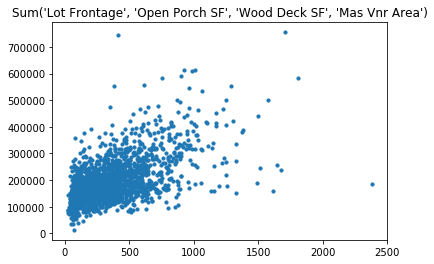

In [50]:
# Sum up rows of the four column and store into a new one
data_df['Continuous Sum'] = data_df[['Lot Frontage', 'Open Porch SF', 'Wood Deck SF', 'Mas Vnr Area' ]].sum(axis=1)

# Scatter plot of the result
plt.scatter(data_df['Continuous Sum'], data_df['SalePrice'], s=10)
plt.title("Sum('Lot Frontage', 'Open Porch SF', 'Wood Deck SF', 'Mas Vnr Area')")
plt.show()


Héhéhé... What a surprise, summing those columns gives me an interesting information. There is a correlation between this sum and the *Sale Price*.

Let's keep this new column and drop the other ones.



In [51]:
addColumnToDropList(['Lot Frontage', 'Open Porch SF', 'Wood Deck SF', 'Mas Vnr Area'])

Columns flaged as 'to be removed': 2nd Flr SF,Enclosed Porch,Lot Frontage,Extra Flr SF,3Ssn Porch,Pool Area,Misc Val,BsmtFin SF 2,Mas Vnr Area,Wood Deck SF,Low Qual Fin SF,Screen Porch,Open Porch SF


Ok, let's drop the columns that we've flagged to be.

In [52]:
dropAndEncode()

Size of the dataframe BEFORE applying one-hot encoding: (2707, 255)
Size of the dataframe AFTER applying one-hot encoding: (2707, 255)
  Drop columns: {'2nd Flr SF', 'Enclosed Porch', 'Lot Frontage', 'Extra Flr SF', '3Ssn Porch', 'Pool Area', 'Misc Val', 'BsmtFin SF 2', 'Mas Vnr Area', 'Wood Deck SF', 'Low Qual Fin SF', 'Screen Porch', 'Open Porch SF'}
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2707, 242)


#### Outliers

Now that we're done with continuous columns cleaning, it's time to remove outliers.

To identify them, let's draw scatter plots with the remaining columns using a z_factor=10 to not remove outliers.

Drawing graphs 3 x 2 (number of column = 6)


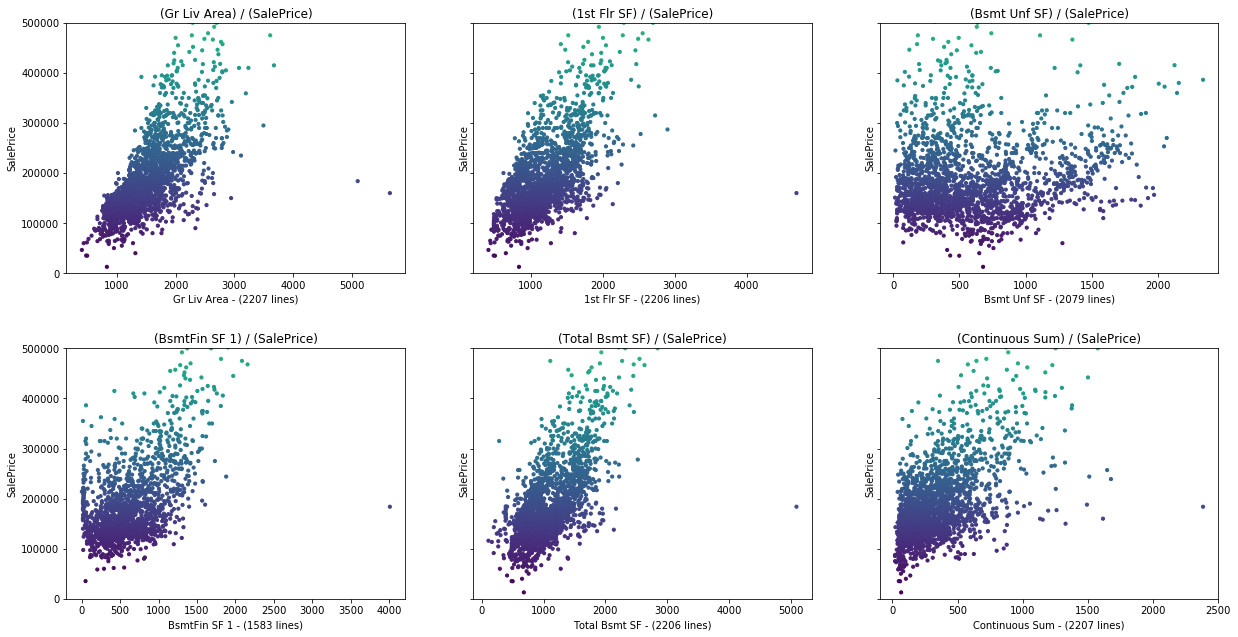

In [53]:
continuous_column=['Gr Liv Area', '1st Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'Total Bsmt SF', 'Continuous Sum']

drawScatterPlot(getTrainDataset(), continuous_column, graph_per_line=3, figsize=(20,10), z_factor=10, polyfit_deg=0)


Previous scatter plots looks like evidence: We have outliers that should be removed from our Train dataset.

The simplest and *not so good* way, use a visual analysis to determine outliers:

* Gr Liv Area: Remove values > 4000
* 1st Flr SF: Remove values > 3000
* BsmtFin SF 1: Remove values > 2500
* Total Bsmt SF: Remove values > 3000
* Continuous Sum: Remove values > 2000


In [54]:
# Indentify outliers according to the previous rules

temp_df=getTrainDataset()

outliers=np.any(
    (
        temp_df['Gr Liv Area'] > 4000,
        temp_df['1st Flr SF'] > 3000,
        temp_df['BsmtFin SF 1'] > 2500,
        temp_df['Total Bsmt SF'] > 3000,
        temp_df['Continuous Sum'] > 2000
    ), axis=0
)

print("Number of rows containing outliers using the 'not so good' approach:",temp_df[outliers].shape[0])



Number of rows containing outliers using the 'not so good' approach: 5


We've found 5 rows to be removed, that's acceptable.

The second and more robust way to identify outliers use the zscore function.

At first, I will evaluate how many rows we will have to remove depending on the zscore factor we choose.

In [55]:
# work on the Train dataset only
temp_df=getTrainDataset().copy()

# Name of the continuos columns to evaluate
continuous_column=['Gr Liv Area', '1st Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'Total Bsmt SF', 'Continuous Sum']

# Calculate zscore for the our continuos columns
print("Calculate zscore for columns:", continuous_column)
zscore_values = zscore(temp_df[continuous_column])

# Evaluate the zscore factor we will use
for factor in [2, 2.5, 3, 3.5]:
    # Build an array of boolen where True = np.abs(zscore) is lower than factor
    zscore_bool = np.abs(zscore_values) < factor

    # Get number of rows that will be removed
    nb_rows=temp_df[~zscore_bool.all(axis=1)].shape[0]
    
    # print result:
    print("zscore factor={:4} will remove {:4} rows ({:.2f}% of the dataset)".format(factor,nb_rows,nb_rows/temp_df.shape[0]*100))

Calculate zscore for columns: ['Gr Liv Area', '1st Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'Total Bsmt SF', 'Continuous Sum']
zscore factor=   2 will remove  342 rows (15.50% of the dataset)
zscore factor= 2.5 will remove  150 rows (6.80% of the dataset)
zscore factor=   3 will remove   70 rows (3.17% of the dataset)
zscore factor= 3.5 will remove   41 rows (1.86% of the dataset)


zscore factor = 3 should be a good compromise between removing outliers and loosing information. Do not forget that we've identified rows with outliers on 6 columns and informations on all the other one might be pertinent.

Size of the dataframe BEFORE removing outliers: (2707, 242)
Rebuild global dataset with train_df (2137, 242) and test_df (500, 242)
Size of the dataframe AFTER removing outliers: (2637, 242)
Drawing graphs 3 x 2 (number of column = 6)


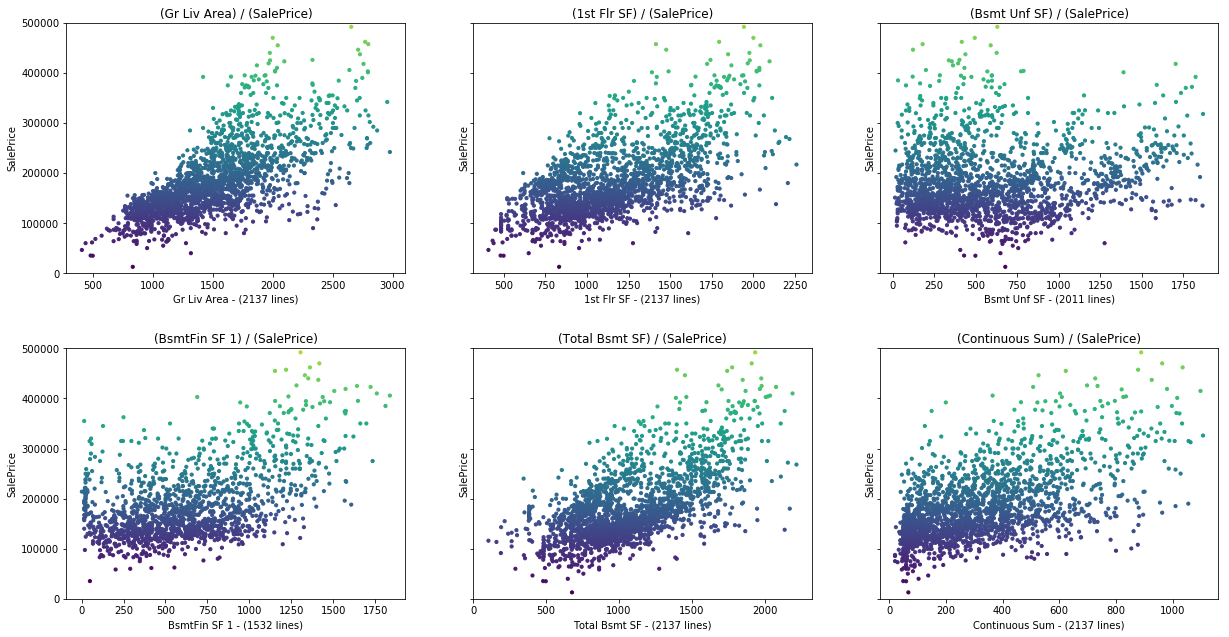

In [56]:
# Rebuild dataset removing outliers
Z_SCORE_FACTOR=3

print("Size of the dataframe BEFORE removing outliers:", data_df.shape)

# Build an array of boolen where True = np.abs(zscore) is lower than factor
zscore_bool = np.abs(zscore_values) < Z_SCORE_FACTOR

concatTrainAndTestDataset(temp_df[zscore_bool.all(axis=1)], getTestDataset())

print("Size of the dataframe AFTER removing outliers:", data_df.shape)

drawScatterPlot(getTrainDataset(), continuous_column, graph_per_line=3, figsize=(20,10), z_factor=10, polyfit_deg=0)

#### Polynomial increase for 'Total Bsmt SF', 'Bsmt Un SF' and 'BsmtFin SF'

Looking at the polyfit linear regression of these three column, I would suggest to re-engineer them using a polynomial increase approach, degree=2 for 'Total Bsmt SF', degree=3 for the two others.

Add the new columns in the whole dataset.

> Note: We have to l0g transform those values to avoid value too large for dtype('float64') when fitting estimator.

Drawing graphs 3 x 3 (number of column = 8)


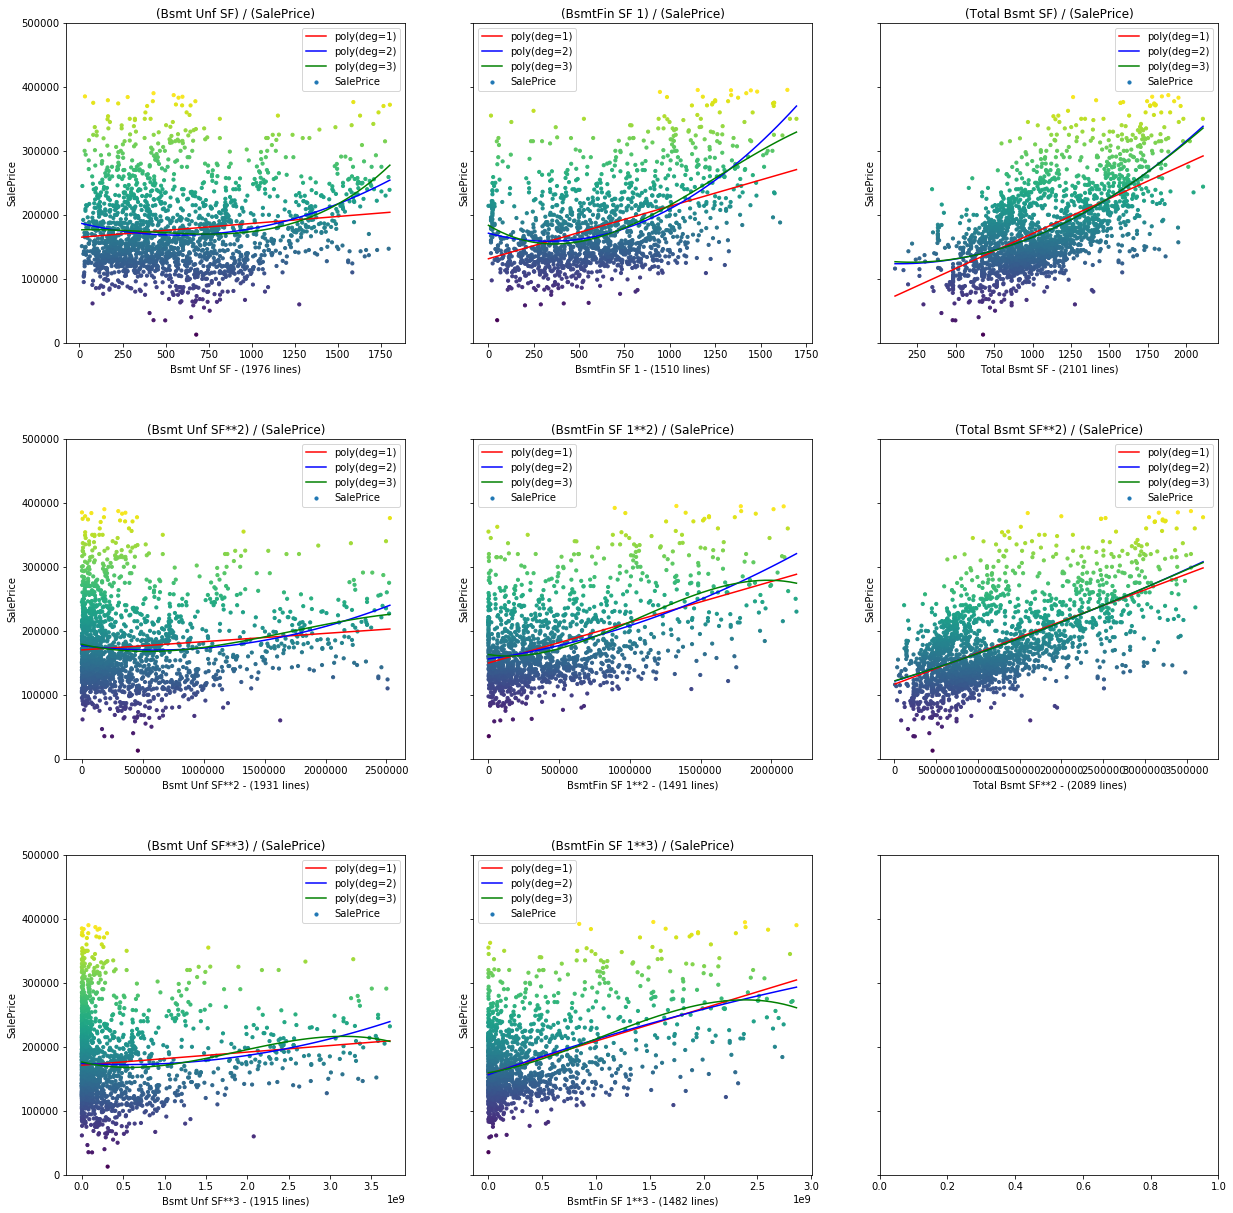

In [57]:
# Feature increase with polynomial approach
data_df['Total Bsmt SF**2'] = data_df['Total Bsmt SF']**2

data_df['BsmtFin SF 1**2'] = data_df['BsmtFin SF 1']**2
data_df['BsmtFin SF 1**3'] = data_df['BsmtFin SF 1']**3

data_df['Bsmt Unf SF**2'] = data_df['Bsmt Unf SF']**2
data_df['Bsmt Unf SF**3'] = data_df['Bsmt Unf SF']**3


# Draw scatter plot with the Train dataset only (Test dataset has NaN values in SalePrice)
polynomial_columns=['Bsmt Unf SF', 'BsmtFin SF 1', 'Total Bsmt SF','Bsmt Unf SF**2', 'BsmtFin SF 1**2', 'Total Bsmt SF**2','Bsmt Unf SF**3', 'BsmtFin SF 1**3']
drawScatterPlot(getTrainDataset(), polynomial_columns, graph_per_line=3, figsize=(20,20), z_factor=3, polyfit_deg=3)



### And what about 'SalePrice' ?

Right, we've cleaned and engineered all the features of our dataset, but what about the result vector, 'SalePrice' ?

Without any surprise, as we've already played with this dataset in a previous course unit, 'SalePrice' column should be transformed using np.log10() function.

Why ? Well, look at the distrbutions of its values:

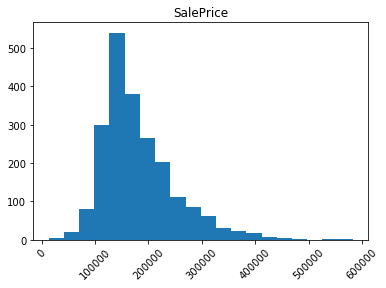

In [58]:
data_df.hist(column='SalePrice', bins=20, grid=False, xrot=45)
plt.show()

The histogram shows values that could be normally distributed if using a log10 transformation.

Before transforming values with np.log10, we should remove outliers from this columns.

> Note: I've decided here to re-use the zscore factor choosen when removing outliers in feature column.

In [59]:
# work using Train dataset
temp_df=getTrainDataset().copy()

# Calculate zscore for 'SalePrice' column
print("Calculate zscore for 'SalePrice' column")
zscore_values = zscore(temp_df[['SalePrice']])

# Rebuild dataset removing 'SalePrice' outliers
print("Size of the dataframe BEFORE removing 'SalePrice' outliers:", data_df.shape)

# Build an array of boolen where True = np.abs(zscore) is lower than factor
zscore_bool = np.abs(zscore_values) < Z_SCORE_FACTOR

concatTrainAndTestDataset(temp_df[zscore_bool.all(axis=1)], getTestDataset())

print("Size of the dataframe AFTER removing 'SalePrice' outliers:", data_df.shape)

Calculate zscore for 'SalePrice' column
Size of the dataframe BEFORE removing 'SalePrice' outliers: (2637, 247)
Rebuild global dataset with train_df (2106, 247) and test_df (500, 247)
Size of the dataframe AFTER removing 'SalePrice' outliers: (2606, 247)


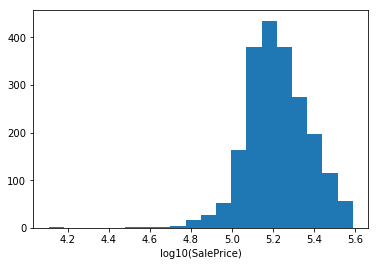

In [60]:
temp_df=getTrainDataset().copy()

temp_df['SalePrice']=np.log10(temp_df.SalePrice)

plt.hist(temp_df.SalePrice, bins=20)
plt.xlabel('log10(SalePrice)')
plt.show()

That looks much more as an efficient distribution for our upcoming model fitting work.

Let's rebuild our global dataframe using this new 'SalePrice' column.

In [61]:
concatTrainAndTestDataset(temp_df, getTestDataset())

Rebuild global dataset with train_df (2106, 247) and test_df (500, 247)


That's all folks for this first big part of the project.

Let's move on to model fitting and prediction ;-)

## Build cleaned and adapted CSV files

As explained at the begining of this dataset, the cleaning result will be written back to two CSV files to be used in the Notebook *house-prices-solution-2-of-2.ipynb*

In [62]:
print("Writing cleaned and adapted CSV files...")
getTrainDataset().to_csv(os.path.join('data','house-prices-cleaned.csv'), index=False)
getTestDataset().to_csv(os.path.join('data','house-prices-test-cleaned.csv'), index=False)
print("... done")

Writing cleaned and adapted CSV files...
... done


It's now time to get into the second Notebook :-)